# 7.3 小批量随机梯度下降

In [1]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

1.0.0


## 7.3.1 读取数据

In [2]:
def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('../../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0) # 标准化
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
           torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape

torch.Size([1500, 5])

## 7.3.2 从零开始实现

In [3]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [4]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.243605, 0.014335 sec per epoch


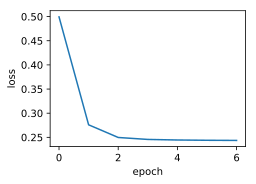

In [5]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.243433, 0.270011 sec per epoch


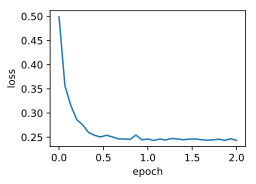

In [6]:
train_sgd(0.005, 1)

loss: 0.242805, 0.078792 sec per epoch


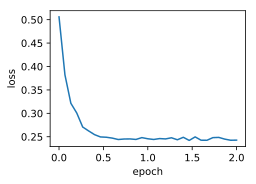

In [7]:
train_sgd(0.05, 10)

## 7.3.3 简洁实现

In [8]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用 （与原书不同的是这里第一个参数优化器函数而不是优化器的名字）
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X), y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.994093, 0.072296 sec per epoch


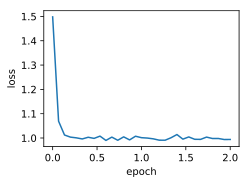

In [9]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)